In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster \
    import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN 
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import InterclusterDistance
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import shapiro

In [2]:
bzcat = pd.read_csv('data/bzcat_clean_noNaN.csv')
bzcat.drop(columns=['Unnamed: 0', 'RA_sin', 'RA_cos', 'Dec_sin'], 
           inplace=True)

In [3]:
bzcat.columns

Index(['BZCAT5 Source name', 'Class', 'Rad_opt_sp_index', 'alpha_2.3-4.8',
       'alpha_4.8-7.7', 'var_4.8', 'var_7.7', 'comoving_distance_Mpc', 'g-r',
       'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4', 'g_var',
       'r_var', 'i_var', 'z_var', 'y_var', 'Opt_uv_sp_index',
       'Opt_X_sp_index'],
      dtype='object')

In [4]:
alphas = ['alpha_2.3-4.8', 'alpha_4.8-7.7'] #, 'alpha_7.7-11.2', 'alpha_11.2-21.7']
radio_vars = ['var_4.8', 'var_7.7']
colors_panstarrs = ['g-r', 'r-i', 'i-z', 'z-y']
colors_wise = ['w1-w2', 'w2-w3', 'w3-w4']
opt_vars = ['g_var', 'r_var', 'i_var', 'z_var', 'y_var']

**Scaling**

In [15]:
cols = list(bzcat.columns)
cols.remove('BZCAT5 Source name')
cols.remove('Class')
mm_scaler = MinMaxScaler()
bzcat_scaled = pd.DataFrame(mm_scaler.fit_transform(bzcat[cols]), columns=cols)

**PCA**

In [7]:
cols = [
    'Rad_opt_sp_index', 'alpha_2.3-4.8', 'alpha_4.8-7.7', 
    'comoving_distance_Mpc', 'y-w1', 'Opt_uv_sp_index', 'Opt_X_sp_index'
]
model_df = bzcat_scaled[cols]

In [8]:
pca = PCA(n_components=1)
model_df['radio_var'] = pca.fit_transform(bzcat_scaled[radio_vars])
model_df['color_panstarrs'] = pca.fit_transform(bzcat_scaled[colors_panstarrs])
model_df['color_wise'] = pca.fit_transform(bzcat_scaled[colors_wise])
model_df['opt_var'] = pca.fit_transform(bzcat_scaled[opt_vars])

cols_copy = ['radio_var', 'color_panstarrs', 'color_wise', 'opt_var']
bzcat[cols_copy] = model_df[cols_copy]
#cols_drop = alphas + radio_vars + colors_panstarrs + colors_wise + opt_vars
#blcat.drop(columns=cols_drop, inplace=True)

**Number of clusters**

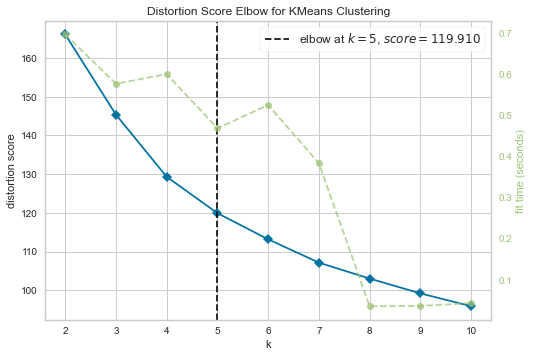

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
vis_distortion = KElbowVisualizer(KMeans())
vis_distortion.fit(model_df)
vis_distortion.show()

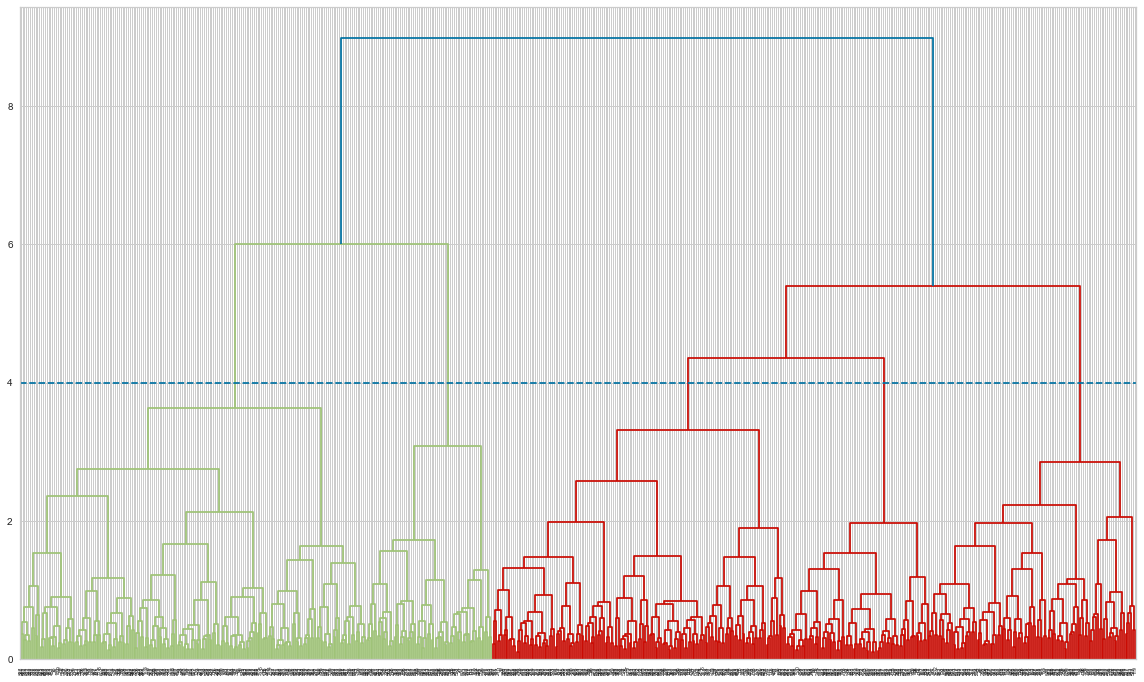

In [10]:
tree = AgglomerativeClustering(n_clusters=5, linkage='ward')
cl_pred = tree.fit_predict(model_df)
blcat['cluster_tree'] = cl_pred

# linkage: single, complete, average, weighted, centroid, median, ward
linked = linkage(model_df, 'ward')
plt.figure(figsize=(20, 12))
dendrogram(Z=linked,
            orientation='top',
            #labels=cl_pred,
            distance_sort='descending')
plt.axhline(linestyle='--', y=4)
plt.show()

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

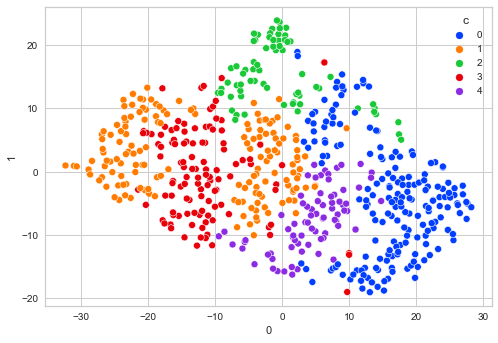

In [11]:
tsne = TSNE(n_components=2, perplexity=35, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = blcat['cluster_tree']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

**k-means, 5 clusters**

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

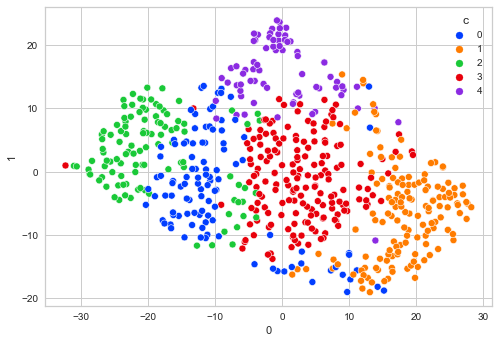

In [12]:
kmeans = KMeans(n_clusters=5, random_state=42)
blcat['cluster_kmeans'] = kmeans.fit_predict(model_df)
tsne = TSNE(n_components=2, perplexity=35, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = blcat['cluster_kmeans']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

In [13]:
kmeans = KMeans(n_clusters=5, random_state=42)
blcat['cluster_kmeans'] = kmeans.fit_predict(model_df)
tsne = TSNE(n_components=3, perplexity=40, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = blcat['cluster_kmeans']
fig = px.scatter_3d(x=df_tsne[0], y=df_tsne[1], z=df_tsne[2],
              color=df_tsne['c'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


**Gaussian Mixture 5 components**

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



<AxesSubplot:xlabel='0', ylabel='1'>

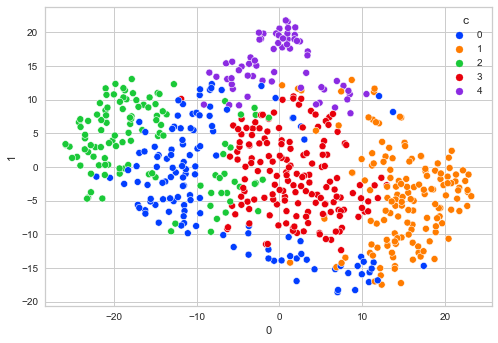

In [14]:
gmixture = GaussianMixture(n_components=5, covariance_type='spherical',
                           random_state=42)
blcat['cluster_gm'] = gmixture.fit_predict(model_df)

tsne = TSNE(n_components=2, perplexity=40, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = blcat['cluster_gm']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

**Spectral Clustering**

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



<AxesSubplot:xlabel='0', ylabel='1'>

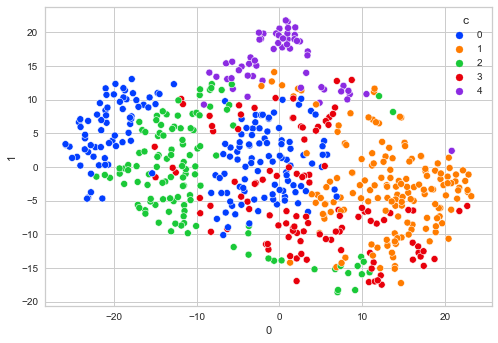

In [15]:
spectral = SpectralClustering(n_clusters=5, random_state=42)
blcat['cluster_sp'] = spectral.fit_predict(model_df)

tsne = TSNE(n_components=2, perplexity=40, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = blcat['cluster_sp']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

**DBScan**

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



<AxesSubplot:xlabel='0', ylabel='1'>

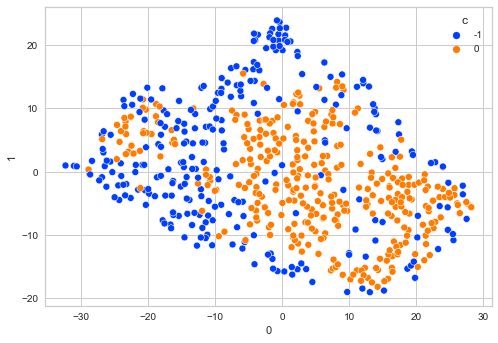

In [16]:
db = DBSCAN(eps=0.3, min_samples=5)
blcat['cluster'] = db.fit_predict(model_df)

tsne = TSNE(n_components=2, perplexity=35, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = blcat['cluster']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

---

In [17]:
blcat.drop(columns=['cluster', 'cluster_tree', 'cluster_sp'], inplace=True)

In [18]:
blcat[blcat['BZG']==1]

,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,alpha_7.7-11.2,alpha_11.2-21.7,var_7.7,var_4.8,comoving_distance_Mpc,log_nuF_4.8,g-r,...,BZG,BZQ,BZU,alpha,radio_var,color_panstarrs,color_wise,opt_var,cluster_kmeans,cluster_gm
17,0.318,-0.225,-0.558,-0.518,1.269,0.080,0.207,444.657331,-13.281914,0.584801,...,1,0,0,0.046410,-0.333928,-0.017285,0.785203,-0.072112,4,4
21,0.493,-0.291,-0.381,-0.690,0.071,0.087,0.353,1023.879100,-13.147215,0.921999,...,1,0,0,0.166861,-0.244823,-0.016716,0.573411,-0.077897,4,4
22,0.501,-0.347,0.008,0.365,0.390,0.496,0.507,838.457258,-13.369064,1.185601,...,1,0,0,-0.057495,0.199161,0.106412,0.265662,0.013110,4,4
81,0.691,0.270,-0.705,-0.968,-1.746,0.171,0.217,1215.811924,-12.510393,0.965001,...,1,0,0,0.410054,-0.248939,-0.199456,-0.398638,-0.045885,3,0
101,-0.039,-1.151,0.270,-0.505,0.126,0.381,0.239,140.553664,-13.068034,0.777200,...,1,0,0,0.100839,-0.053423,-0.087421,0.561360,0.180287,4,4
175,0.075,-0.587,-0.477,-0.804,-0.322,0.443,0.220,257.468872,-12.732242,0.525899,...,1,0,0,0.296466,-0.010194,0.170316,0.732386,-0.146139,4,4
226,0.465,-0.117,0.019,0.036,0.026,0.126,0.118,1105.158140,-13.281914,1.233599,...,1,0,0,-0.025285,-0.344439,0.110017,0.289532,-0.226066,4,4
298,0.488,-0.500,-0.555,-0.399,-0.133,0.819,0.767,668.652381,-12.755105,0.896099,...,1,0,0,0.247738,0.628461,0.113785,0.151852,0.046494,0,0
321,0.406,0.114,-0.167,-0.070,0.236,0.491,0.543,274.657778,-12.980884,0.835399,...,1,0,0,-0.026892,0.215270,0.158718,0.362653,-0.156213,4,4
329,0.690,0.014,-0.875,-0.537,-1.212,0.377,0.313,850.437845,-12.262609,0.950101,...,1,0,0,0.396593,-0.014838,0.251794,0.056132,0.242284,4,0


In [19]:
blcat[blcat['cluster_kmeans']==3][['BLLac','BZQ','BZG','BZU']].sum()

BLLac      3
BZQ      162
BZG        1
BZU        6
dtype: int64

In [20]:
blcat[blcat['cluster_kmeans']==1][['BLLac','BZQ','BZG','BZU']].sum()

BLLac      1
BZQ      143
BZG        0
BZU        1
dtype: int64

In [21]:
blcat[blcat['cluster_kmeans']==2][['BLLac','BZQ','BZG','BZU']].sum()

BLLac    11
BZQ      89
BZG       0
BZU       8
dtype: int64

In [22]:
blcat[blcat['cluster_kmeans']==0][['BLLac','BZQ','BZG','BZU']].sum()

BLLac    23
BZQ      69
BZG       3
BZU      11
dtype: int64

In [23]:
blcat[blcat['cluster_kmeans']==4][['BLLac','BZQ','BZG','BZU']].sum()

BLLac    22
BZQ      25
BZG      12
BZU      13
dtype: int64

In [24]:
print(blcat['BZG'].sum())

16


In [25]:
print(blcat['BZQ'].sum())
print(blcat.shape[0])
print(blcat['BZQ'].sum() / blcat.shape[0])

488
603
0.8092868988391376


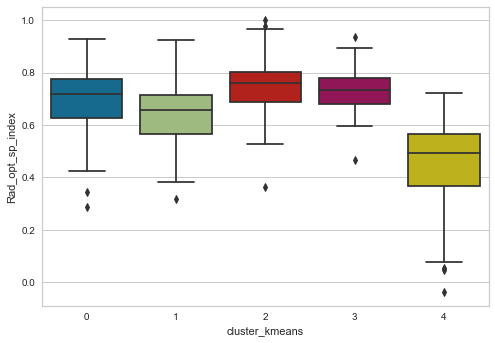

In [26]:
sns.boxplot(data=blcat, y='Rad_opt_sp_index', x='cluster_kmeans');

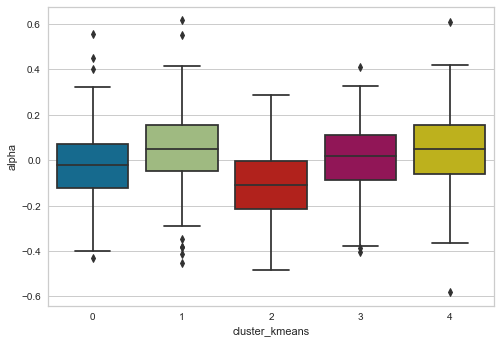

In [27]:
sns.boxplot(data=blcat, y='alpha', x='cluster_kmeans');

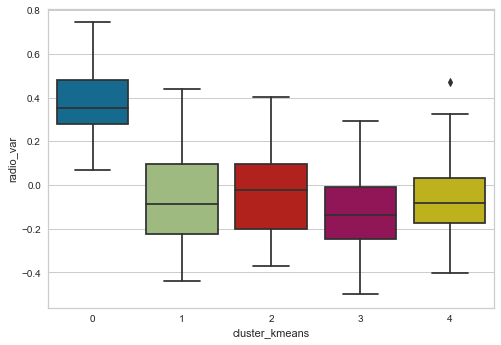

In [28]:
sns.boxplot(data=blcat, y='radio_var', x='cluster_kmeans');

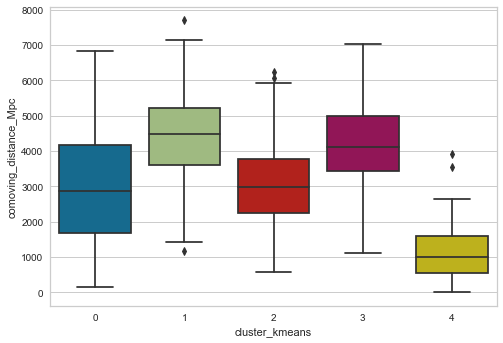

In [29]:
sns.boxplot(data=blcat, y='comoving_distance_Mpc', x='cluster_kmeans');

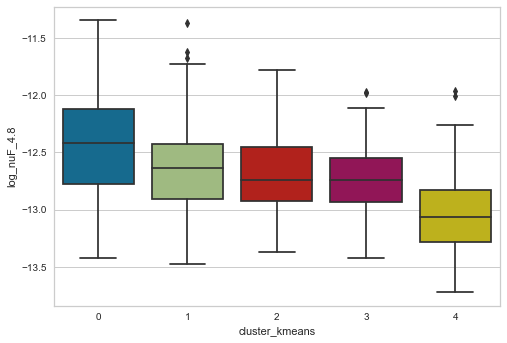

In [30]:
sns.boxplot(data=blcat, y='log_nuF_4.8', x='cluster_kmeans');

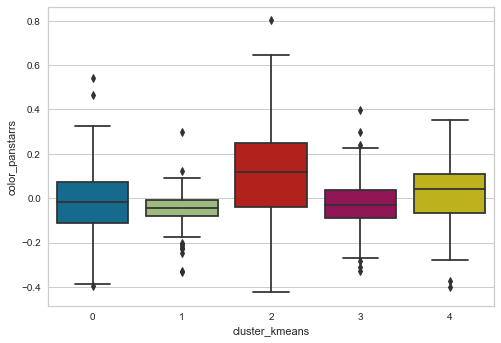

In [31]:
sns.boxplot(data=blcat, y='color_panstarrs', x='cluster_kmeans');

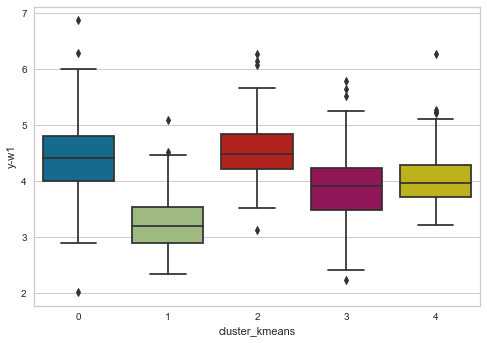

In [32]:
sns.boxplot(data=blcat, y='y-w1', x='cluster_kmeans');

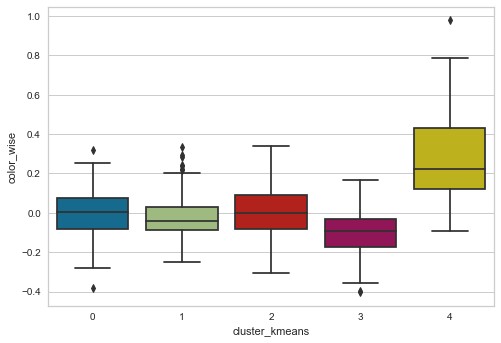

In [33]:
sns.boxplot(data=blcat, y='color_wise', x='cluster_kmeans');

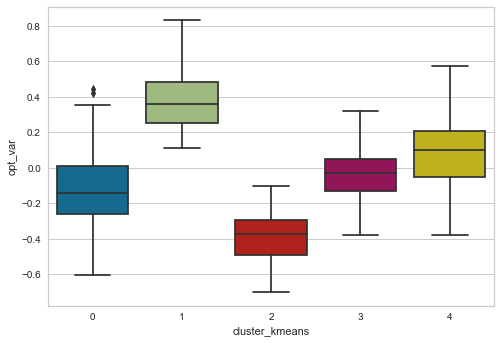

In [34]:
sns.boxplot(data=blcat, y='opt_var', x='cluster_kmeans');